In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Data Load

In [2]:
path_precip = './precip.mon.mean.nc'
path_sst = './sst.mnmean.nc' 
path_hgt = './hgt.mon.mean.nc'

precip_nc = xr.open_dataset(path_precip)
sst_nc = xr.open_dataset(path_sst)
hgt_nc = xr.open_dataset(path_hgt)

print(precip_nc)
print(sst_nc)
print(hgt_nc)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 456)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    version:        V1701
    history:        update 11/2016 V1701
<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2017)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 

C:\Users\admin\anaconda3\lib\site-packages\xarray\conventions.py:492: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


# Data Processing

In [3]:
precip = precip_nc.data_vars['precip']
sst = sst_nc.data_vars['sst']
hgt = hgt_nc.data_vars['hgt']

print(precip.shape)
print(sst.shape)
print(hgt.shape)

(456, 72, 144)
(2017, 89, 180)
(491, 17, 73, 144)


In [4]:
#select level for hgth
hgt_850mb = hgt.sel(level=850)
print(hgt_850mb.shape)

(491, 73, 144)


In [5]:
#creat a function to obtain monthly anomalies
#We need to calculate climatology and anomalies

def monthly_anomalies(variable):
    
    climatology = variable.groupby("time.month").mean("time")
    anomaly = variable.groupby("time.month") - climatology
    return anomaly


In [6]:
precip_ano = monthly_anomalies(precip)
sst_ano = monthly_anomalies(sst)
hgt850_ano = monthly_anomalies(hgt_850mb)

print(precip_ano.shape)
print(sst_ano.shape)
print(hgt850_ano.shape)

(456, 72, 144)
(2017, 89, 180)
(491, 73, 144)


In [7]:
# composite El Nino / La Nina years
# https://ggweather.com/enso/oni.htm

elninos = ['1983-01', '1987-01', '1988-01', '1992-01', '1995-01', '1998-01', '2003-01', '2010-01']
laninas = ['1989-01', '1996-01', '1999-01', '2000-01', '2008-01', '2011-01', '2012-01']

elnino_precip = 0
elnino_sst = 0
elnino_hgt = 0

lanina_precip = 0
lanina_sst = 0
lanina_hgt = 0

for elnino in elninos :
    elnino_precip += precip_ano.sel(time=elnino)[0]/len(elninos)
    elnino_sst += sst_ano.sel(time=elnino)[0]/len(elninos)
    elnino_hgt += hgt850_ano.sel(time=elnino)[0]/len(elninos)

for lanina in laninas : 
    lanina_precip += precip_ano.sel(time=lanina)[0]/len(laninas)
    lanina_sst += sst_ano.sel(time=lanina)[0]/len(laninas)
    lanina_hgt += hgt850_ano.sel(time=lanina)[0]/len(laninas)
    
print(elnino_hgt)
print(lanina_hgt)

<xarray.DataArray 'hgt' (lat: 73, lon: 144)>
array([[-4.9329834, -4.9329834, -4.9329834, ..., -4.9329834, -4.9329834,
        -4.9329834],
       [-4.8566895, -5.076172 , -5.298828 , ..., -4.335327 , -4.484741 ,
        -4.5335693],
       [-4.57312  , -5.3658447, -5.8841553, ..., -3.4085693, -4.0061035,
        -4.350586 ],
       ...,
       [18.570068 , 18.15857  , 18.170776 , ..., 19.024414 , 18.813965 ,
        18.655518 ],
       [18.652466 , 18.65857  , 18.542725 , ..., 18.679932 , 18.686035 ,
        18.618896 ],
       [18.954224 , 18.954224 , 18.954224 , ..., 18.954224 , 18.954224 ,
        18.954224 ]], dtype=float32)
Coordinates:
    level    float32 850.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time     datetime64[ns] 1983-01-01
    month    int64 1
<xarray.DataArray 'hgt' (lat: 73, lon: 144)>
array([[-33.82584  , -33.82584  , -33.82584  , ..., -33.82584 

In [8]:
def plot_precip(ax, variable, title):
    m =  Basemap(
        
        lon_0=180, lat_0=0,
        llcrnrlon=0, llcrnrlat=-70, urcrnrlon=360, urcrnrlat=80,
        resolution = 'i', ax=ax)

    coord=np.meshgrid(variable.lon, variable.lat)

    m.drawcoastlines(linewidth=0.75, color='gray') #draw coastlines
    
    m.drawparallels(np.linspace(-60,80,5), labels=[1,0,0,0], linewidth=0)
    m.drawmeridians(np.linspace(0,360,5), labels=[0,0,0,1], linewidth=0)
    
    precip_contourf = m.contourf(coord[0],coord[1],variable,cmap = plt.cm.Spectral, levels=20 ) #contour map
    cbar = m.colorbar(precip_contourf, ax=ax,pad=0.3, location = 'bottom')
    cbar.ax.tick_params(labelsize=10)   
   
    ax.set_title(title)

In [9]:
def plot_sst(ax, variable, title):
    m =  Basemap(
        
        lon_0=180, lat_0=0,
        llcrnrlon=0, llcrnrlat=-70, urcrnrlon=360, urcrnrlat=80,
        resolution = 'i', ax=ax)

    coord=np.meshgrid(variable.lon, variable.lat)

    m.drawcoastlines(linewidth=0.75, color='gray') #draw coastlines
    m.drawlsmask(land_color='lightgray')    #Draw land-sea mask image.
    
    m.drawparallels(np.linspace(-80,80,5), labels=[1,0,0,0], linewidth=0)
    m.drawmeridians(np.linspace(0,360,5), labels=[0,0,0,1], linewidth=0)
    
    sst_contourf = m.contourf(coord[0],coord[1],variable,cmap = plt.cm.bwr, levels=20)
    cbar = m.colorbar(sst_contourf, ax=ax, pad=0.3, location = 'bottom')
    cbar.ax.tick_params(labelsize=10)        
    ax.set_title(title)

In [10]:
def plot_hgt(ax, variable, title):        
        m = Basemap( 
            projection = 'ortho',
            lon_0=180, lat_0=20,
            resolution = 'i', ax=ax)
        
        # create meshgrid covering the whole globe with ...
        # conforming dimensions of the `data`
        coord=np.meshgrid(variable.lon, variable.lat) # basic mesh in lon, lat (degrees)
        lons, lats = m(coord[0],coord[1])  # convert (lon,lat) to map (x,y)
        #more info. https://stackoverflow.com/questions/50939821/aligning-data-contourf-on-basemap
        
        m.drawcoastlines(linewidth=0.75, color='gray')
        hgt_contourf = m.contourf(lons, lats, variable, cmap = plt.cm.coolwarm, levels=30)
        
        ax.set_title(title)
        cbar = m.colorbar(hgt_contourf, ax=ax, location = 'bottom')
        cbar.ax.tick_params(labelsize=10)

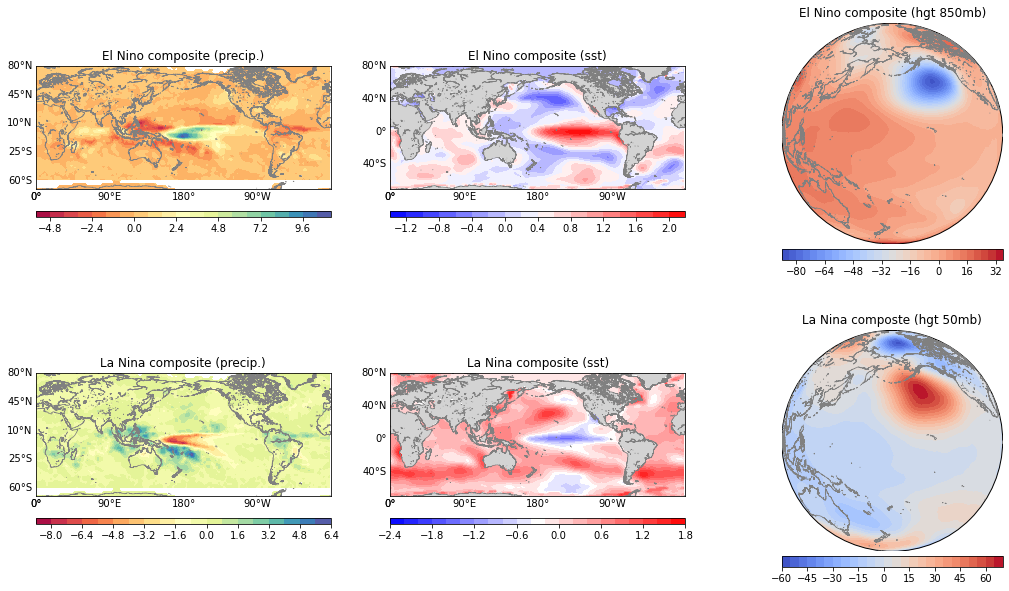

In [11]:
nrow = 2
ncol = 3

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(18,10))
plt.subplots_adjust(wspace = 0.2, hspace= 0.3)

plot_precip(ax[0][0],elnino_precip,'El Nino composite (precip.)')
plot_precip(ax[1][0],lanina_precip,'La Nina composite (precip.)')
plot_sst(ax[0][1],elnino_sst, 'El Nino composite (sst)')
plot_sst(ax[1][1],lanina_sst, 'La Nina composite (sst)')
plot_hgt(ax[0][2],elnino_hgt, 'El Nino composite (hgt 850mb)')
plot_hgt(ax[1][2],lanina_hgt, 'La Nina composte (hgt 50mb)')